# Exploring the Titanic Dataset (Python version)
Anton Fefilov
2 november 2016

## 1 Introduction
This is my second attempt to make ML research myself after awesome Andrew Ng's Coursera course on Machine Learning. As a basis for the first attempt I took the awesome kernel [Exploring the Titanic Dataset](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic) authored by Megan Risdal and reworked it with Python. Also I took a lot of useful information for this work in [A Journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic) kernel by Omar El Gabry. Unexpectedly my experiment has been failed: after finishing and submitting results to the Kaggle I was scored with 0. One of the possible variants to continue investigations is to try to figure out what's wrong with my calculations, but I don't want to go this way. And that is why.
As I followed Megan's flow while trying to solve Titanic's challenge, work has been divided into three parts:

*    Feature engineering
*    Missing value imputation
*    Prediction!

But I strongly feel I should start with prediction in the simplest form, evaluate it and submit results to the Kaggle in order to understand how succesfull my prediction is. After this I should engineer any new features and reiterate the process above and after every iteration I will see if feature engineering bring any impact.

### 1.1 Load and check data

In [85]:
# Load packages

# pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

# configure seaborn
sns.set_style('whitegrid')

# draw graphics inline
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from patsy import dmatrices

Now that our packages are loaded, let’s read in and take a peek at the data.

In [86]:
# get titanic & test csv files as a DataFrame
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

# add dummy Survived variable to the test set in order to use patsy's formulas
test_df['Survived'] = 0.5

In [87]:
# preview the train data structure
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
# get sense of variables and datatypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [89]:
# and the same steps for the test data structure
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.5
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.5


In [90]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 39.3+ KB


We’ve got a sense of our variables, their class type, and the first few observations of each. We know we’re working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren’t 100% illuminating, here’s what we’ve got to deal with:

| Variable Name | Description |
| --- | --- |
| PassengerId | Passenger's id |
| Survived | Survived (1) or died (0) |
| Pclass | Passenger’s class |
| Name | Passenger’s name |
| Sex | Passenger’s sex |
| Age | Passenger’s age |
| SibSp | Number of siblings/spouses aboard |
| Parch | Number of parents/children aboard |
| Ticket | Ticket number |
| Fare | Fare |
| Cabin | Cabin |
| Embarked | Port of embarkation |

## 1.2 Preparation 

In [91]:
def make_experiment(formula, clf, train_data):
    "function_docstring"
    
    # Create the train datasets from formula 
    y, X = dmatrices(formula, data=train_data, return_type='dataframe')

    # RandomForestClassifier expects a 1 demensional NumPy array, so we convert
    y = np.asarray(y).ravel()

    # fit the model to our training data
    clf.fit(X, y) 

    # and evaluate it's performance
    score = clf.score(X,y)
    print("Score on training data: %s" % score)
    
    scores = cross_val_score(clf, X, y, cv=2)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    
    # get features importances
    importances = clf.feature_importances_
    indices = np.argsort(importances)
   
    # show features importances
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), X[indices])
    plt.xlabel('Relative Importance')
    
    return clf

In [92]:
def predict(formula, iteration_number, clf, test_data):
    "function_docstring"
    
    _, X_test = dmatrices(formula, data=test_data, return_type='dataframe')

    y_test = clf.predict(X_test).astype(int)

    submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": y_test
    })

    submission.to_csv("output/titanic_iteration_%s.csv" % iteration_number, index=False)

In [93]:
# instantiate classificator
random_forest = RandomForestClassifier(n_estimators=100, max_features=None, n_jobs=-1, min_samples_split=1, random_state=50)

# 2. Iterations

## 2.1 Iteration #1

### 2.1.1 Preparation


In [94]:
train_df[['Pclass', 'Sex', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Pclass    891 non-null int64
Sex       891 non-null object
SibSp     891 non-null int64
Parch     891 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ KB


### 2.1.2 Experiment

In [95]:
# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + SibSp + Parch'

Score on training data: 0.817059483726
Accuracy: 0.771 (+/- 0.001)


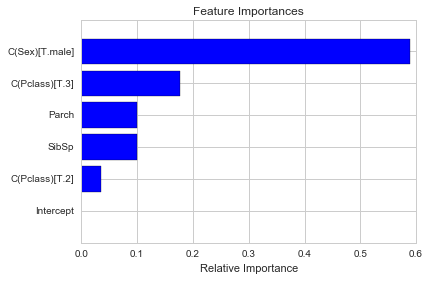

In [96]:
trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

In [97]:
test_df[['Pclass', 'Sex', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
Pclass    418 non-null int64
Sex       418 non-null object
SibSp     418 non-null int64
Parch     418 non-null int64
dtypes: int64(3), object(1)
memory usage: 13.1+ KB


### 2.1.3 Prediction #1

In [98]:
predict(formula, iteration_number=1, clf=trained_random_forest, test_data=test_df)

After submitted this prediction I was scored with 0.76555, seems very close to model evaluation so I will use cross validation in my future iterations.

## 2.2 Iteration #2

### 2.2.1 Preparation

Let's take a look at the Age variable as intuitevly it can make prediction more concise. 

In [99]:
# combine train and test datasets into one to ipmute missing values
titanic_df = train_df.append(test_df, ignore_index=True).copy()

In [100]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

263

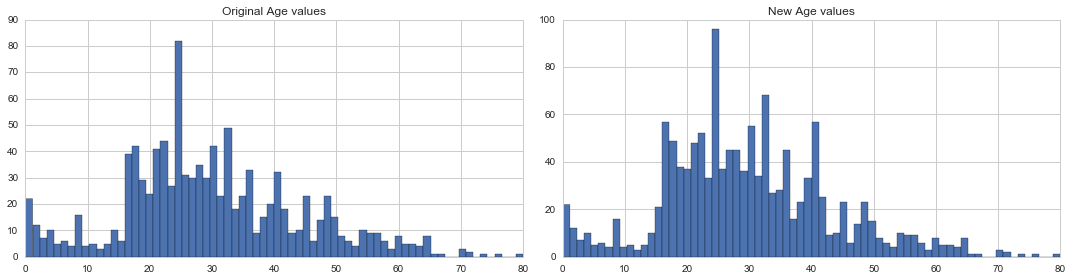

In [101]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

axis1.set_title('Original Age values')
axis2.set_title('New Age values')

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# get average, std, and number of NaN values
average_age = titanic_df["Age"].mean()
std_age = titanic_df["Age"].std()
count_nan_age = titanic_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_age = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# fill NaN values in Age column with random values generated
age_hypothese = titanic_df["Age"].copy()

age_hypothese[np.isnan(age_hypothese)] = rand_age

# plot imputed Age values
age_hypothese.astype(int).hist(bins=70, ax=axis2)

plt.tight_layout()

Things look good, so let’s replace our Age vector in the original data with the new values

In [102]:
titanic_df["Age"] = age_hypothese

In [103]:
# Show number of missing Age values
titanic_df["Age"].isnull().sum()

0

In [104]:
# Split data back into train dataframe
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 34.9+ KB


### 2.2.2 Experiment

Score on training data: 0.918069584736
Accuracy: 0.784 (+/- 0.032)


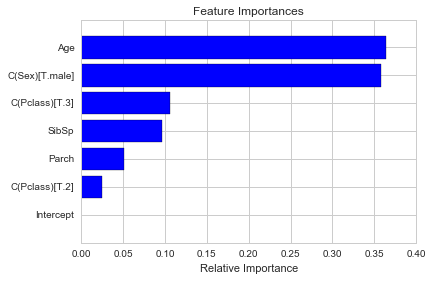

In [105]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

This is not better than first iteration so let's go forward, to the next iteration.

## 2.3 Iteration #3

It seems that adding new variable Age with much imputed values does not help. Let's try to reduce number of sets, remove NaN values and keep only original data.

### 2.3.1 Preparation

In [106]:
# Make a copy of the titanic data frame
titanic_df['Title'] = titanic_df['Name']

# Grab title from passenger names
titanic_df["Title"].replace(to_replace='(.*, )|(\\..*)', value='', inplace=True, regex=True)

In [107]:
# Titles with very low cell counts to be combined to "rare" level
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
titanic_df['Title'].replace(rare_titles, "Rare title", inplace=True)

# Also reassign mlle, ms, and mme accordingly
titanic_df['Title'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)

In [108]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Title     891 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 41.8+ KB


### 2.3.2 Experiment

Score on training data: 0.925925925926
Accuracy: 0.776 (+/- 0.009)


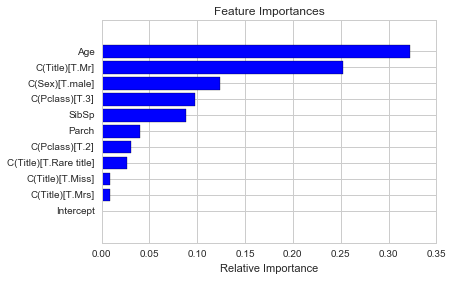

In [109]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Title)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

## 2.4 Iteration #4

### 2.4.1 Preparation

In [110]:
# Create a family size variable including the passenger themselves
titanic_df["Fsize"] = titanic_df.SibSp + titanic_df.Parch + 1

# Discretize family size
titanic_df.ix[titanic_df.Fsize > 4, "Fsize"] = "large"
titanic_df.ix[titanic_df.Fsize == 1, "Fsize"] = 'singleton'
titanic_df.ix[(titanic_df.Fsize < 5) & (titanic_df.Fsize > 1), "Fsize"] = "small"

In [111]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'Fsize']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Title     891 non-null object
Fsize     891 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 48.8+ KB


### 2.4.2 Experiment #4

Score on training data: 0.925925925926
Accuracy: 0.778 (+/- 0.014)


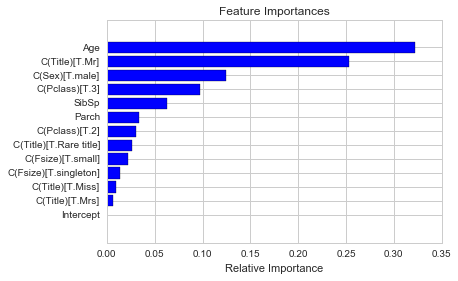

In [112]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Title) + C(Fsize)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

### 2.4.3 Prediction #4

In [113]:
# Split data back into train and test dataframes
test_df = titanic_df[891:]; test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Title', 'Fsize']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 7 columns):
Pclass    418 non-null int64
Sex       418 non-null object
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Title     418 non-null object
Fsize     418 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 22.9+ KB


In [114]:
predict(formula, iteration_number=4, clf=trained_random_forest, test_data=test_df)

## 2.5 Iteration #5

### 2.5.1 Preparation
Let's remove SibSp and Parch variables as they already included in Fsize feature and see the score and accuracy

### 2.5.2 Experiment

Score on training data: 0.912457912458
Accuracy: 0.788 (+/- 0.016)


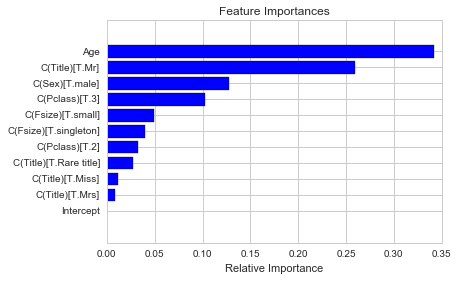

In [115]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

Accuracy became slightly better so I guess we can remove this features from model.

## 2.6 Iteration #6 (add Fare feature)

### 2.6.1 Preparation

In [116]:
# Let's find passengers with missing Fare feature
np.where(titanic_df["Fare"].isnull())[0]

array([1043])

In [117]:
titanic_df.ix[[1043]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,0.5,3701,Mr,singleton


This is a third class passenger who departed from Southampton (‘S’). Let’s visualize Fares among all others sharing their class and embarkment (n = 494).

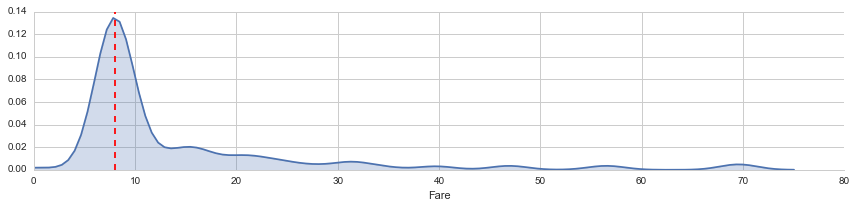

In [118]:
facet = sns.FacetGrid(titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')], aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 80))

fare_median = titanic_df[(titanic_df['Pclass'] == 3) & (titanic_df['Embarked'] == 'S')]['Fare'].median()
plt.axvline(x=fare_median, color='r', ls='--')

From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is `$`8.05.

In [119]:
# Replace missing fare value with median fare for class/embarkment
titanic_df.loc[[1043],'Fare'] = fare_median

In [120]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass    891 non-null int64
Sex       891 non-null object
Age       891 non-null float64
Title     891 non-null object
Fsize     891 non-null object
Fare      891 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 41.8+ KB


### 2.6.2 Experiment

Score on training data: 0.986531986532
Accuracy: 0.781 (+/- 0.042)


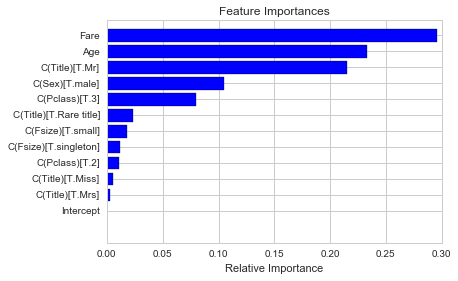

In [140]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize) + Fare' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

### 2.6.3 Prediction #6

In [122]:
# Split data back into train and test dataframes
test_df = titanic_df[891:]; test_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 6 columns):
Pclass    418 non-null int64
Sex       418 non-null object
Age       418 non-null float64
Title     418 non-null object
Fsize     418 non-null object
Fare      418 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 19.7+ KB


In [123]:
predict(formula, iteration_number=6, clf=trained_random_forest, test_data=test_df)

After this submission I was scored with 0.75120 what is not improvement of the first attempt. Keep going.

## 2.7 Iteration #7 (add Embarked feature)

### 2.7.1 Preparation

In [124]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Fsize          1309 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [125]:
# Let's find passengers with missing Embarked feature
np.where(titanic_df["Embarked"].isnull())[0]

array([ 61, 829])

In [126]:
titanic_df.ix[[61,829]]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,singleton
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,singleton


We will infer their values for embarkment based on present data that we can imagine may be relevant: **passenger class** and **fare**. We see that they paid **`$`80** and **`$`80** respectively and their classes are **1** and **1** . So from where did they embark?

In [127]:
# Get rid of our missing passenger IDs
embark_fare_df = titanic_df.drop([61,829], axis=0)

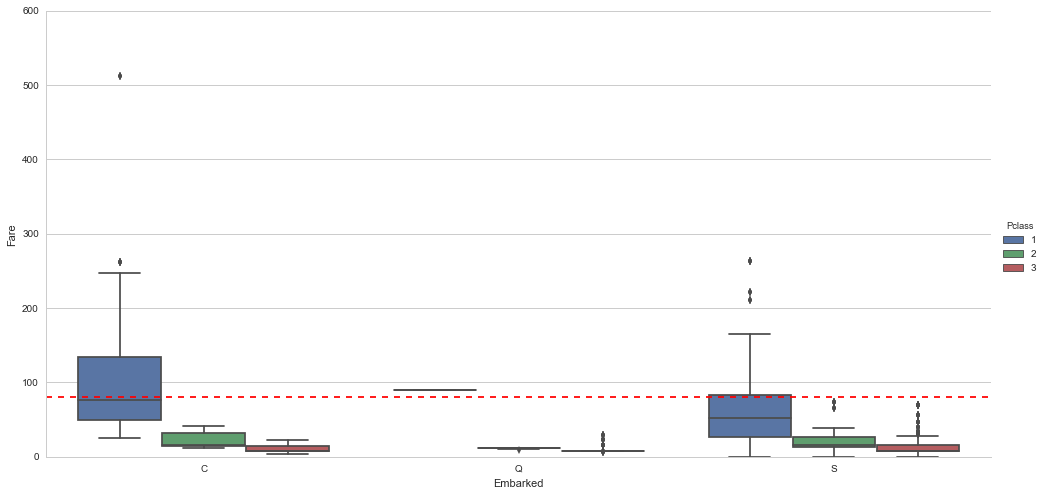

In [128]:
# Let's visualize embarkment, passenger class ...
sns.factorplot(x='Embarked',y='Fare', hue='Pclass', kind="box",order=['C', 'Q', 'S'],data=embark_fare_df, size=7,aspect=2)

# ... and median fare
plt.axhline(y=80, color='r', ls='--')

Voilà! The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with ‘C’.

In [129]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
titanic_df.loc[[61,829],"Embarked"] = 'C'

In [130]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare', 'Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
Title       891 non-null object
Fsize       891 non-null object
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 48.8+ KB


### 2.7.2 Experiment

Score on training data: 0.986531986532
Accuracy: 0.785 (+/- 0.049)


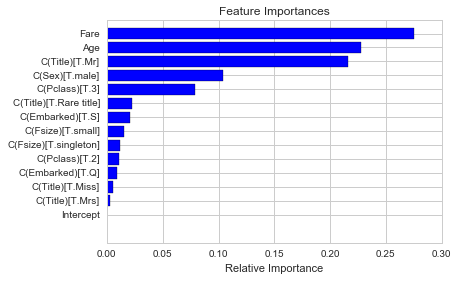

In [131]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize) + Fare + C(Embarked)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

## 2.8 Iteration #8 (add Mother/Child feature)

### 2.8.1 Preparation

Now that we know everyone’s age, we can create a couple of new age-dependent variables: **Child** and **Mother**. A child will simply be someone under 18 years of age and a mother is a passenger who is:
* female
* is over 18
* has more than 0 children (no kidding!)
* does not have the title ‘Miss’.

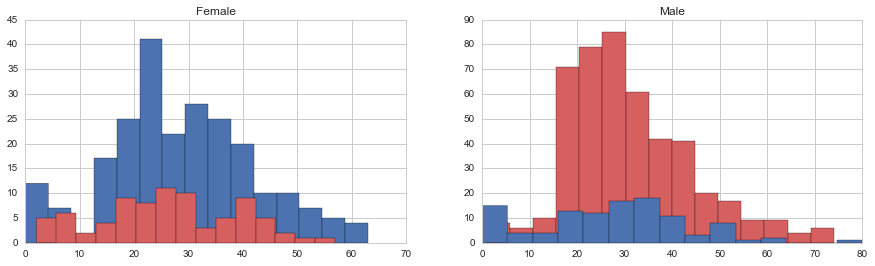

In [132]:
# peaks for survived/not survived passengers by their age
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Female')
axis2.set_title('Male')

titanic_df[(titanic_df['Sex'] == "female") & (titanic_df['Survived'] == 1)]['Age'].astype(int).hist(bins=15, ax=axis1, color="#4C72B0")
titanic_df[(titanic_df['Sex'] == "female") & (titanic_df['Survived'] == 0)]['Age'].astype(int).hist(bins=15, ax=axis1, color="#D65F5F")

titanic_df[(titanic_df['Sex'] == "male") & (titanic_df['Survived'] == 0)]['Age'].astype(int).hist(bins=15, ax=axis2, color="#D65F5F")
titanic_df[(titanic_df['Sex'] == "male") & (titanic_df['Survived'] == 1)]['Age'].astype(int).hist(bins=15, ax=axis2, color="#4C72B0")

# peaks for survived/not survived passengers by their age
#facet = sns.FacetGrid(titanic_df[titanic_df['Sex'] == "female"], hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

#facet = sns.FacetGrid(titanic_df[titanic_df['Sex'] == "male"], hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

In [133]:
# Create the column child, and indicate whether child or adult

def child_or_adult(age):
    return 'Child' if age < 16 else 'Adult'

titanic_df['Child'] = titanic_df['Age'].apply(child_or_adult)

In [134]:
# Show counts
titanic_df.groupby(["Child", "Survived"]).size().unstack()

Survived,0.0,0.5,1.0
Child,,,
Adult,510,379,290
Child,39,39,52


Looks like being a child doesn’t hurt, but it’s not going to necessarily save you either! We will finish off our feature engineering by creating the **Mother** variable. Maybe we can hope that mothers are more likely to have survived on the Titanic.

In [135]:
# Adding Mother variable
titanic_df['Mother'] = 'Not Mother'

def choose_mother(person):
    sex, parch, age, title, mother = person
    return 'Mother' if (sex == 'female' and parch > 0 and age > 18 and title != 'Miss') else mother
       

titanic_df['Mother'] = titanic_df[['Sex', 'Parch', 'Age', 'Title', 'Mother']].apply(choose_mother, axis=1)

In [136]:
# Show counts
titanic_df.groupby(["Mother", "Survived"]).size().unstack()

Survived,0.0,0.5,1.0
Mother,,,
Mother,16,30,38
Not Mother,533,388,304


In [137]:
# Split data back into train and test dataframes
train_df = titanic_df[:891]; train_df[['Pclass', 'Sex', 'Age', 'Title', 'Fsize', 'Fare', 'Embarked', 'Mother', 'Child']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
Title       891 non-null object
Fsize       891 non-null object
Fare        891 non-null float64
Embarked    891 non-null object
Mother      891 non-null object
Child       891 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 62.7+ KB


### 2.8.2 Experiment

Score on training data: 0.986531986532
Accuracy: 0.787 (+/- 0.035)


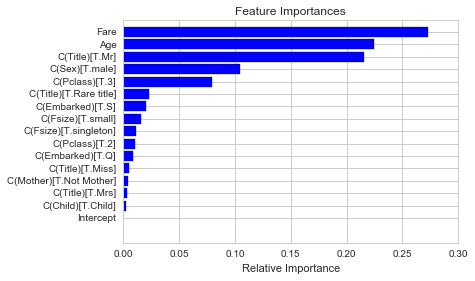

In [138]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + C(Title) + C(Fsize) + Fare + C(Embarked) + C(Mother) + C(Child)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

Score on training data: 0.986531986532
Accuracy: 0.797 (+/- 0.033)


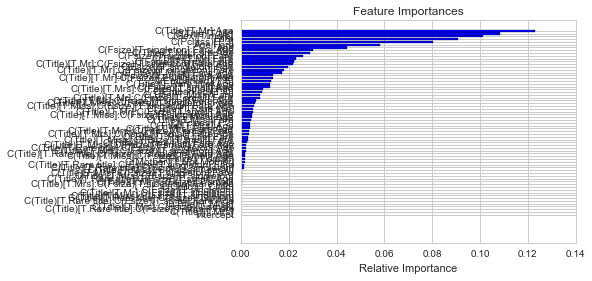

In [152]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + Age*Fare + Age*Age + C(Title) + C(Fsize) + C(Title)*C(Fsize)*Fare + C(Title)*C(Fsize)*Age + C(Title)*C(Fsize)*Fare*Age + Fare + Fare*Fare + C(Embarked) + C(Mother) + C(Child)' 

trained_random_forest = make_experiment(formula, clf=random_forest, train_data=train_df)

In [154]:
# Split data back into train and test dataframes
test_df = titanic_df[891:];

predict(formula, iteration_number=8, clf=trained_random_forest, test_data=test_df)